# Ligand Docking with AlphaFold Structure

As we have observed in the Docking workflow, it was not possible to a large subset of ligands. This was seemingly exclusively the case for ligands that differed structurally from salicylic acid, the co-crystallized ligand of the `5F1A.pdb` structure. For these ligands, molecular docking either 
1. calculated docking poses with large *positive* free binding energy (kcal/mol) estimations, indicating a very poor affinity, or 
2. was unable to create any docking pose altogether. 

This was observed even for experimentally validated potent COX-2 antagonists like Valdecoxib (`CHEMBL865`) and Aclofenac (`CHEMBL94081`) (both of which have gained market approval), which, in theory, should be able to generate sensible docking poses. 

When salicylic acid (SAL) binds to the COX-2 receptor, the new set of molecular interactions induces a conformation change of the binding site residues, which alters the geometry of the binding pocket. We hypothesize that this conformation change, which gets captured in the crystallographic structure of the COX-2 protein bound to SAL (`5F1A`), *biases* this structural model to SAL-like ligands. This, in turn, would make docking non SAL-like ligands more difficult, even in the case of experimentally validated and potent antagonists.

In this notebook, we will attempt to perform docking using a protein model generated using the protein structure prediction model AlphaFold 2, developed by DeepMind.

## The AlphaFold 2 Model
What follows is a short, limited explanation of how the AlphaFold 2 model produces accurate three dimensional protein models based on the methodology described in the 2021 *Nature* publication (Jumper et al. 2021)[1], and the FAQ hosted on the AlphaFold database website.[2]

AlphaFold 2 first performs a multiple sequence alignments (MSA) of the target protein's amino acid sequence with other amino acid sequences from public databases, like UniProt. It also uses the experimental structures (from PDB) of other homologous protein as 'templates' with which it forms an initial picture of the three-dimensional structure of the target. 

It then takes these two sources of input and uses a deep learning transformer-based approach (called an '*evoformer*') to progressively improve the understanding of 1. the sequence alignments, in which it determines which aligned amino acid pairs are more related and which areas of the sequence are more important for determining the structure, and 2. something that is called the 'pair representation', which represents the three-dimensional position of every pair of amino acid residues in the protein, and also predicts which residues interact with each other. The *evoformer* network progressively builds a model of the interactions within the protein using these two processes whose outputs function as each others inputs in 48 iterations.  

Then, after 48 iterations, AlphaFold 2 uses the original amino acid sequence and updated pair representation to generate a three-dimensional structure. *Note: we do not fully understand how this is achieved, other than it is done in three iterations which refine the three-dimensional structure according to a loss function called the frame aligned point error (FAPE) instead of the more common RMSD of atomic positions function that is commonly used in protein folding prediction algorithms.*

Molecular docking approaches using AlphaFold structures have been used successfully to find novel ligands for multiple protein targets[3,4]. However, a paper comparing the performance of high-throughput docking of AlphaFold-predicted structures and experimentally validated structures performed better (as judged by calculated Enrichment Factor and Hit Rate), including for the related COX-1 protein.[5] Still, as the experimental `5F1A` structure is not able to produce sensible docking poses with a subset of our ligands, we will try the AlphaFold structure, anyway. 


## Protein Alignment using PyMOL

*Note: We attempted to do the entire workflow (downloading the AlphaFold protein and aligning / exporting it using PyMOL) inside this Jupyter notebook, but we couldn't get it to work. Instead we have placed the aligned protein in our GitHub repository. The performed steps are described below.*


Firstly, the AlphaFold structure (`.pdb`) was downloaded from the AlphaFold database[6]. Then using PyMOL[7], the AlphaFold and `5F1A` structures were aligned based on their entire structures:

```
load '5F1A.pdb', reference
load `AF-P35354-F1-model_v4.pdb`, mobile

align mobile reference
```

Which aligned the protein structures (RMSD = 0.358 Ä):

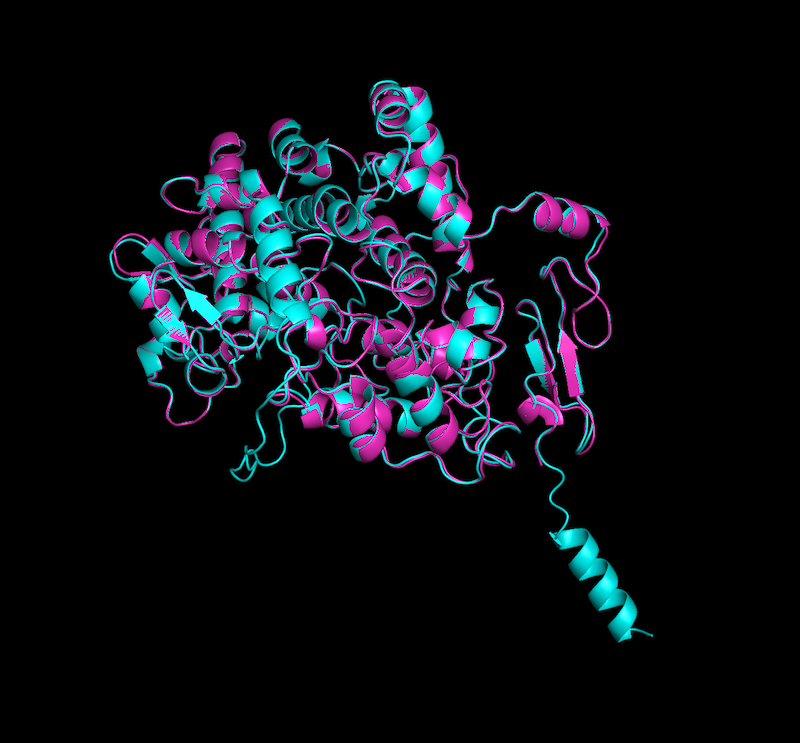

**Figure 1.** AlphaFold 2 (blue) and 5F1A (pink) structures aligned using PyMOL.

Then, the aligned AlphaFold structure was exported (`alpha_aligned.pdb`). In this case, the AlphaFold structure was aligned to the coordinates of the 5F1A structure, which aligns the positions of their binding sites. This, in turn, makes it possible to place a docking box on the AlphaFold structure based on the unaltered coordinates of the SAL-ligand from the original 5F1A structure. 

### Difference of *apo* and *holo* state binding sites of the Alpha/5F1A structures
An important aspect of the experimental 5F1A structure is that it is a model of the COX-2 *holo*-protein, which depicts the protein in complex with its ligand. The AlphaFold structure, without ligand, depicts the protein in its *apo*-state. The question then arises if it is proper to align these two structures, since there could be a difference in conformation induced by the ligand not accounted for. It has been found, however, that upon ligand binding, the backbones of the proteins do not reposition significantly, and that the side chains display the greatest amount of flexibility.[8] This strengthens the viability of aligning these two protein models.

### Alignment Based on Whole Structures
In the current workflow, the two protein models were aligned based on their whole structures (backbone and all residue side chains). Alternatively, the alignment could have been performed using just the binding site residues to improve overlapping of the binding sites. 

In [1]:
# import requests

# url = "https://alphafold.ebi.ac.uk/files/AF-P35354-F1-model_v4.pdb"
# response = requests.get(url)
# alphaName = "alpha_COX2"
# currentDir = os.getcwd()

# if response.status_code == 200:
#     with open(f"{alphaName}.pdb", "wb") as file:
#         file.write(response.content)
#         print(f"AlphaFold structure downloaded and saved as '{alphaName}.pdb' at {currentDir}.")
# else:
#     print(f"Something went wrong. You can try downloading the .pdb file manually from {url}")

In [2]:
# from ipymol import viewer as pymol
# pymol.do("load alpha_COX2.pdb, mobile")
# pymol.do("load 5F1A_prepped.pdb, reference")
# pymol.do("align mobile, reference")

## Protein preparation
Now we have procured the aligned AlphaFold COX-2 structure, the rest of the protein preparation steps (e.g. protonation, combining protein and ligand `.pdb`-files) are the same as those performed for the `5F1A`-structure.

In [3]:
!pip install biopython==1.81
!pip install prolif

  Using cached biopython-1.81-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached biopython-1.81-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting uninstall: biopython
    Found existing installation: biopython 1.83
    Uninstalling biopython-1.83:
      Successfully uninstalled biopython-1.83
  Using cached prolif-2.0.3-py3-none-any.whl.metadata (19 kB)
Using cached prolif-2.0.3-py3-none-any.whl (5.1 MB)


In [4]:
## This code block imports python modules to work with during the lab.
# modules
import py3Dmol
import nglview
import os
import shutil
import pandas as pd
import glob
import sys
#from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
from Bio.PDB import PDBList, MMCIFParser, Select, PDBIO
import Bio.Align
from pathlib import Path
import rdkit

# local scripts
from scripts import viewer
from scripts import bio_align




from vina import Vina
#import pybel

from rdkit import Chem

from rdkit.Chem import AllChem, Draw

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf

import shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import os
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(22)

/opt/conda/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [5]:
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# Check whether the directory is there
try:
    os.mkdir('Bioinformatics')
except:
    print("Directory already exists")
os.chdir('Bioinformatics')

Directory already exists


In [6]:
LIGAND_CODE = "SAL" # SAL is cocrystallized ligand of 5F1A
TARGET_PDB_ID = 'alpha_aligned'

Protonation with LePro.

In [7]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

'alpha_aligned_prepped.pdb'

In [8]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [9]:


view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(TARGET_PDB_ID),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

It can be observed that the SAL-ligand is positioned in the new AlphaFold-structure. Now we will continue with docking.

# Docking

In [10]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')

Directory already exists


# IMPORTANT: double lines in .pdb files.
Due to the fact that 5F1A has been crystallized as dimer, the .pdb files `5F1A_prepped.pdb` and `ligand-SAL.pdb` contain the sequence for two proteins.
This gives issues when trying to calculate the docking box.
The function underneath will cleanup the .pdb files and make them suitable for subsequent docking.

In [11]:
def remove_lines(file_name, start_line, end_line):
    
    with open(file_name, 'r') as file:
        lines = file.readlines()

    del lines[start_line-1:end_line]

    with open(file_name, 'w') as file:
        file.writelines(lines)

    print(f"Lines {start_line} to {end_line} deleted successfully and changes saved to {file_name}.")

## Importing (and cutting up) the .pdb files

In [12]:
PDBCODE = 'alpha_aligned' # 51FA = human COX2
LIGAND_CODE = 'SAL' # Add the ligand code, SAL = salic. acid (cocrystallized ligand van 5F1A)
shutil.copy('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE), '{}_prepped.pdb'.format(PDBCODE))
shutil.copy('../Bioinformatics/ligand-{}.pdb'.format(LIGAND_CODE), 'ligand-{}.pdb'.format(LIGAND_CODE))

remove_lines('ligand-SAL.pdb', 12, 22) # should be around 899 B after removing

Lines 12 to 22 deleted successfully and changes saved to ligand-SAL.pdb.


In [13]:
test_smiles = [
                      
    'OC1=CC=CC=C1C(O)=O', # Salicylic acid (SAL)
    "O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl", #aclofenac
    "O=C(O)C1=CC=NC=C1OC", #sal alt 1, pyridine en methoxy
    "OC1=CC=C2C(C=CC2)=C1C(O)=O", # sal alt 2, met extra ring
    "C1=CC=C(C(=C1)C(=O)O)C(=O)O", #phtalic acid
    "NC1=CC=CC=C1C(O)=O", #sal alt met N ipv O
    "OC1=CC=CC=C1C(N)=O",  #sal alt met C(N)=O ipv C(O)=O
    "CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3", #VALDECOXIB met extra N en methylgroep
    "CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3", #VALDECOXIB met extra N"
    "CS(=O)(=O)c1ccc(cc1)C2=C(C(=O)OC2)c3ccccc3", # rofecoxib
]

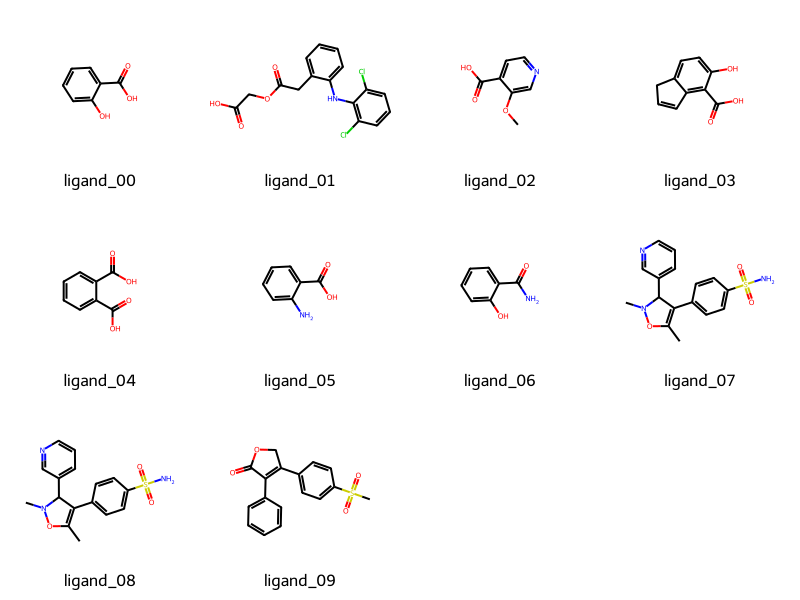

In [14]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img


## Docking with Vina AutoDock

In [15]:
from math import isnan, isinf

def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # A copy of molecule
    mol = Chem.Mol(mol)

    # If flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to get rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # Route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # Direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # Remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # Mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # Break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # Close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # No more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # Reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # Properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

## Box definition

Since we are using the same ligand `.pdb` file for this docking procedure, the box definition (based on the radius of gyration of the protein and the coordinates of the ligand) is the same as for the `5F1A` docking.

In [16]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

Radius of Gyration = 2.02


In [17]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # Extract coordinates 
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # Calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Center Of Geometry = [42.043, 23.986, 240.114]


### Docking

In [18]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [19]:
# From this code block, all code block belows need to be ran seperately for each ligand. 
# You change the name of the ligand, so ligand_00 (reference ligand), ligand_01, ligand_02, etc.
LIGAND_TO_DOCK = 'ligand_00' # The ligand you want to dock.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)


We now perform the actual docking, please note that:


***This step takes a while!***

In [20]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses(f'docking_results_{LIGAND_TO_DOCK}_AlphaFold.pdbqt', n_poses=10, overwrite=True)

with open(f"docking_results_{LIGAND_TO_DOCK}_AlphaFold.pdbqt") as infile:
    saving = False
    molecule = []
    i = 0
    for line in infile:
        if not saving:
            if line.startswith("MODEL"):
                saving = True
        elif line.startswith("ENDMDL"):
            saving = False
            fp = open(f"docking_results_{LIGAND_TO_DOCK}_AlphaFold_pose{i}.pdbqt", "w")
            fp.writelines(molecule)
            fp.close()
            i += 1
            molecule = []
        else:
            molecule.append(line)

Computing Vina grid ... done.
Performing docking (random seed: -937802345) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [21]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock(f'docking_results_{LIGAND_TO_DOCK}_AlphaFold_pose0.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -5.517 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 4.05


In essence, the predicted binding affinities do not differ substantially from the predictions made with the `5F1A` model, which is a good sign.

### 3D visualization shows a plausible binding pose of SAL

It can be observed that the SAL ligand is positioned relatively similar to the co-crystallized (fixed) SAL ligand in the best scored pose.

In [22]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [23]:
# Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

## Verifying Docking Pose of SAL with Interactions ('sanity check')
After having docked the SAL ligand with the AlphaFold 2 structure, we will now examine the interactions displayed in the docking poses. 

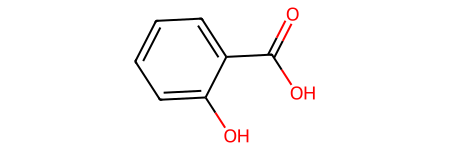

In [24]:
template = Chem.MolFromSmiles(
    test_smiles[0] #SAL
)
template

In [25]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
os.chdir('Docking')

# load .pdbqt of poses from docking run for ligand
pdbqt_files = sorted(glob.glob('docking_results_ligand_00_AlphaFold_pose*.pdbqt'))
pdbqt_files
pose_iterable = plf.pdbqt_supplier(pdbqt_files, template)

# Specify alphafold strucutre and create Mol-file
protein_file = str("alpha_aligned_prepped.pdb")
rdkit_prot = Chem.MolFromPDBFile(protein_file, removeHs=False)
protein_mol = plf.Molecule(rdkit_prot)

# Initiate fingerprint generator
fp = plf.Fingerprint()
# Run on your poses
fp.run_from_iterable(pose_iterable, protein_mol)

  0%|          | 0/10 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7f3e721a98d0>

In the paper co-published with the `5F1A` structure[9], the authors observed the following interactions made by salicylate upon binding:

| Residue | Type of Interaction | Distance (Ä) |
| ------- | ------------------- | ------------ |
| Leu-353 | vd Waals            | 3.67         |
| Leu-384 | vd Waals            | 3.73-3.64    |
| Tyr-385 | vd Waals            | 3.06-3.96    |
| Trp-387 | vd Waals            | 3.31-3.91    |
| Gly-526 | vd Waals            | 3.59-3.97    |
| Ala-527 | vd Waals            | 3.82-3.94    |
| Ser-530 | vd Waals            | 3.80         |

It can be observed that, despite containing salicylic acid / salicylate containing a polar hydroxyl group and a (deprotonated) carboxylic acid group with which it is in theory able to make hydrogen bond and/or ionic interactions, it seems to make exclusively vd Waals interactions, which were all observed to be made with its phenolic and carboxylic *carbon* atoms. 

We will now check if the IFPs of the generated docking pose of SAL contain these key interactions to check whether docking with the AlphaFold structure produces sensible docking results. In the following code block, we will display the percentage (out of 10 generated poses) of poses contain a specific interaction (we have removed the hydrophobic interactions, which seem to co-occur with each vd Waals interaction, for legibility).

In [26]:
df = fp.to_dataframe(index_col="Pose")
# First 5 poses are shown 
# Interaction type (Hydrophobic) hidden
df.drop("Hydrophobic", level="interaction", axis=1, inplace=True)
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand            UNL1                                                         \
protein       VAL509.A   GLY512.A   SER516.A   ALA513.A   TRP373.A   VAL335.A   
interaction VdWContact VdWContact VdWContact VdWContact VdWContact VdWContact   
%                 90.0       80.0       80.0       70.0       60.0       60.0   

ligand                                                                         
protein       SER516.A   LEU338.A   TYR371.A   MET508.A   LEU370.A   PHE367.A  
interaction HBAcceptor VdWContact VdWContact VdWContact VdWContact VdWContact  
%                 50.0       40.0       40.0       30.0       10.0       10.0

At first, it may seem that there are no matching interactions. Upon closer inspection it can be observed that, in fact the interactions with Tyr-385, Trp-387, Gly-526, Ala-527, and Ser-530 are represented in multiple docking poses. It seems that the indexing has been offset by 14 for all amino acid residues (e.g. Tyr-385 becomes Tyr-371, etc.). Nevertheless, it seems that most, but not all, interactions can be found in the docking poses generated with the AlphaFold protein, which strengthens the validity of this approach.

As has been discussed before, the docking procedure might be improved by changing the alignment approach (e.g. by aligning the proteins based only on their binding site residues as reference instead of the whole protein structures). Currently, "expert validation" of each docking pose is still necessary in order to ensure proper alignment and to check the reliability of the results. Automatic screening the docking results could be achieved by only selecting docking poses which display a certain percentage of desired interactions, under the assumption that forming these interactions with specific residues is required for a SAL-like ligand to bind to the target. There is always more to do, more things to improve and tweak, but unfortunately we do not have time. 

Now we have assessed the reliability of this AlphaFold structure, We will end this notebook by trying to solve our initial problem: docking non salicylic acid-like ligands on the COX-2 receptor.

## Docking Rofecoxib with the AlphaFold COX-2 structure
The ligand we will try to dock with the AlphaFold structure is Rofecoxib. This is an experimentally validated COX-2 antagonist that has gained market approval (and subsequently lost it due to being implicated in causing an increased risk of cardiac problems), but we were previously unable to dock using the `5F1A` structure. 

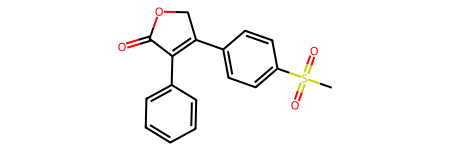

In [27]:
rofecoxib = Chem.MolFromSmiles(
    test_smiles[9] #Rofecoxib
)
rofecoxib

In [28]:
# From this code block, all code block belows need to be ran seperately for each ligand. 
# You change the name of the ligand, so ligand_00 (reference ligand), ligand_01, ligand_02, etc.
LIGAND_TO_DOCK = 'ligand_09' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)


We now perform the actual docking, please note that:


***This step takes a while!***

In [29]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 5 ,
    'size_y' : Rg * 5,
    'size_z' : Rg * 5,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses(f'docking_results_{LIGAND_TO_DOCK}_AlphaFold.pdbqt', n_poses=10, overwrite=True)

with open(f"docking_results_{LIGAND_TO_DOCK}_AlphaFold.pdbqt") as infile:
    saving = False
    molecule = []
    i = 0
    for line in infile:
        if not saving:
            if line.startswith("MODEL"):
                saving = True
        elif line.startswith("ENDMDL"):
            saving = False
            fp = open(f"docking_results_{LIGAND_TO_DOCK}_AlphaFold_pose{i}.pdbqt", "w")
            fp.writelines(molecule)
            fp.close()
            i += 1
            molecule = []
        else:
            molecule.append(line)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -5.517          0          0
   2       -5.282      1.997      3.696
   3       -5.274      2.165      3.465
   4       -5.161      2.553      3.637
   5       -5.111      1.198      2.578
   6         -5.1      2.349      4.266
   7       -4.882      1.248       2.97
   8         -4.3      2.676       4.06
   9       -4.227       1.83      2.537
  10        1.168       2.12      3.034
Computing Vina grid ... done.
Performing docking (random seed: 2126579033) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [30]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock(f'docking_results_{LIGAND_TO_DOCK}_AlphaFold_pose0.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -0.624 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 0.46


The docking of Rafecoxib with the AlphaFold 2 structure was "successful": it generated docking poses, although fewer than the intended 10. The predicted affinity is also very low (-0.581 kcal/mol corresponding to a pCHEMBL of 0.43, compared to pCHEMBL values of approx. 5-8 associated with `CHEMBL122`). Still, as docking scores are unreliable at best[10], we intend to take a closer look at the docking pose and IFPs to verify the validity of these docking results.

In [31]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
# Combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [33]:
# Docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK

with open('{}-complex.pdb'.format(PDBCODE)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view, selection="UNL")
view

NGLWidget()

In [34]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
os.chdir('Docking')

# load .pdbqt of poses from docking run for ligand
pdbqt_files = sorted(glob.glob('docking_results_ligand_09_AlphaFold_pose*.pdbqt'))
pdbqt_files
pose_iterable = plf.pdbqt_supplier(pdbqt_files, rofecoxib)

# Specify alphafold strucutre and create Mol-file
protein_file = str("alpha_aligned_prepped.pdb")
rdkit_prot = Chem.MolFromPDBFile(protein_file, removeHs=False)
protein_mol = plf.Molecule(rdkit_prot)

# Initiate fingerprint generator
fp = plf.Fingerprint()
# Run on your poses
fp.run_from_iterable(pose_iterable, protein_mol)

  0%|          | 0/1 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7f3e715b0890>

In [35]:
df = fp.to_dataframe(index_col="Pose")
# Show only the 5 first poses
# Hide an interaction type (Hydrophobic)
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand             UNL1                                               \
protein        VAL335.A               LEU338.A              SER339.A   
interaction Hydrophobic VdWContact Hydrophobic VdWContact VdWContact   
%                 100.0      100.0       100.0      100.0      100.0   

ligand                                                                \
protein        TYR341.A              PHE367.A   TYR371.A    TRP373.A   
interaction Hydrophobic VdWContact VdWContact VdWContact Hydrophobic   
%                 100.0      100.0      100.0      100.0       100.0   

ligand                                                                \
protein        PHE504.A               VAL509.A              GLY512.A   
interaction Hydrophobic VdWContact Hydrophobic VdWContact VdWContact   
%                 100.0      100.0       100.0      100.0      100.0   

ligand                                                     
protein        ALA513.A              SER516.A    LEU517.A  
interaction Hydrophobic VdWContact VdWContact Hydrophobic  
%                 100.0      100.0      100.0       100.0

In [36]:
fp.plot_lignetwork(pose_iterable[0])

To validate the accuracy of the generated docking pose, we can cross-reference the binding site interactions displayed in this docking pose, with those that were observed in the experimental crystal structure that was published[11]:


| Residue | Type of Interaction    | Distance (Ä) |
| ------- | ---------------------- | ------------ |
| His-90  | "Hydrophilic contact" | 3.56-3.58    |
| Val-349 | Hydrophobic            | 3.46-3.9     |
| Leu-352 | Hydrophobic            | 3.44-3.99    |
| Ser-353 | Hydrophobic            | 3.68-3.81    |
| Tyr-355 | Hydrophobic            | 3.98         |
| Trp-387 | Hydrophobic            | 3.76-3.68    |
| Arg-513 | "Hydrophilic contact" | 3.24         |
| Ala-516 | Hydrophobic            | 3.66         |
| Ile-517 | Hydrophobic            | 3.88         |
| Phe-518 | Hydrophobic            | 3.13-3.89    |
| Val-523 | Hydrophobic            | 3.07-3.99    |
| Gly-526 | Hydrophobic            | 3.89         |
| Ala-527 | Hydrophobic            | 3.37-3.9     |


The generated docking pose displays the hydrophobic interactions with Val-349, Leu-338, Ser-353, Tyr-355, Trp-373, Phe-518, Val-523, Gly-512, and Ala-513 (again, residue numbering is off by 14), however does not seem to capture any hydrophilic contact (H-bonds) with His-90 or Arg-513. Overall this docking pose displays 9 out of the 13 interactions observed in the crystal structure by the authors. The analysis of the IFPs could be improved by not only looking at 1). what kind (hydrophobic, H-bond, etc.) of interaction is formed, and 2). with which binding site residue, but also 3). which atom of the *ligand* is involved in this interaction. This third aspect could be used in order to automatically screen docking poses for the correct binding orientation.

Overall, this result seems promising: most interactions observed in the crystal structure of Rofecoxib in complex with COX-2 are represented in the best scored docking pose resulting from the AlphaFold 2 docking procedure. This ultimately shows us that the AlphaFold 2 structure allows for the docking of both salicylic acid like ligands, as well as ligands remarkably bigger and structurally dissimilar, although a larger, higher-throughput effort, assessing many more ligands and involving scoring the reliability of the docking results, should be performed to shed more light upon the practical utility of this structure. 

## References
1. Jumper, J., Evans, R., Pritzel, A. _et al._ Highly accurate protein structure prediction with AlphaFold. _Nature_ **596**, 583–589 (2021). https://doi.org/10.1038/s41586-021-03819-2
2. Frequently Asked Questions. https://alphafold.ebi.ac.uk/faq. Accessed on September 30th, 2024.
3. Zhu, W., Liu, X., Li, Q., Gao, F., Liu, T., Chen, X., Zhang, M., Aliper, A., Ren, F., Ding, X., & Zhavoronkov, A. (2023). Discovery of novel and selective SIK2 inhibitors by the application of AlphaFold structures and generative models. _Bioorganic & Medicinal Chemistry_, _91_, 117414–117414. https://doi.org/10.1016/j.bmc.2023.117414
4. Díaz-Holguín, A., Saarinen, M., Vo, D. D., Sturchio, A., Branzell, N., Cabeza de Vaca, I., Hu, H., Mitjavila-Domènech, N., Lindqvist, A., Baranczewski, P., Millan, M. J., Yang, Y., Carlsson, J., & Svenningsson, P. (2024). AlphaFold accelerated discovery of psychotropic agonists targeting the trace amine–associated receptor 1. _Science Advances_, _10_(32), eadn1524-. https://doi.org/10.1126/sciadv.adn1524
5. Scardino, V., Di Filippo, J. I., & Cavasotto, C. N. (2023). How good are AlphaFold models for docking-based virtual screening? _iScience_, _26_(1), 105920–105920. https://doi.org/10.1016/j.isci.2022.105920
6. Prostaglandin G/H synthase 2. AF-P35354-F1-v4. https://alphafold.ebi.ac.uk/entry/P35354. Accessed on September 30th, 2024.
7. The PyMOL Molecular Graphics System, Version 3.0 Schrödinger, LLC.
8. Clark, J. J., Benson, M. L., Smith, R. D., & Carlson, H. A. (2019). Inherent versus induced protein flexibility: Comparisons within and between apo and holo structures. _PLoS Computational Biology_, _15_(1), e1006705–e1006705. https://doi.org/10.1371/journal.pcbi.1006705
9. Lucido, M. J., Orlando, B. J., Vecchio, A. J., & Malkowski, M. G. (2016). Crystal Structure of Aspirin-Acetylated Human Cyclooxygenase-2: Insight into the Formation of Products with Reversed Stereochemistry. _Biochemistry (Easton)_, _55_(8), 1226–1238. https://doi.org/10.1021/acs.biochem.5b01378
10. Chen, Y.-C. (2015). Beware of docking. _Trends in Pharmacological Sciences (Regular Ed.)_, _36_(2), 78–95. https://doi.org/10.1016/j.tips.2014.12.001
11. Orlando, B. J., & Malkowski, M. G. (2016). Crystal structure of rofecoxib bound to human cyclooxygenase-2. Acta Crystallographica. Section F, Structural Biology Communications, 72(10), 772–776. https://doi.org/10.1107/S2053230X16014230

